In [1]:
import numpy as np

import random
import h5py
from keras import backend as K
from utility import *
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
from keras.initializers import *
from keras.models import load_model
from keras.losses import *
from sklearn import metrics
from sklearn.preprocessing import *
from scipy.fftpack import dct, idct
from keras.activations import softmax
from sklearn.cluster import KMeans, MiniBatchKMeans
import scipy.io.wavfile as sciwav
import multiprocessing

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt
import glob

import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

# increase recursion limit for adaptive VQ
import sys
sys.setrecursionlimit(40000)

np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

Using TensorFlow backend.


In [2]:
# control amount of GPU memory used
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

In [3]:
# external custom code I wrote
from load_data import *
from windowing import *
from pesq import *
from consts import *
from nn_blocks import *
from transforms import *

In [4]:
# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# number of speech files for train, val, and test
TRAIN_SIZE = 1000
VAL_SIZE = 100
TEST_SIZE = 500

# during training, we evaluate PESQ and RMSE and such on full speech files every epoch, which
# is kind of expensive. so instead of selecting the full training and validation set, we
# randomly select this many waveforms
TRAIN_EVALUATE = 100
VAL_EVALUATE = 100

In [5]:
[train_paths, val_paths, test_paths], \
[train_waveforms, val_waveforms, test_waveforms], \
[train_procwave, val_procwave, test_procwave], \
[train_wparams, val_wparams, test_wparams], \
[train_windows, val_windows, test_windows] = load_data(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)

In [6]:
# flatten all of the train windows into vectors
train_processed = np.array([i for z in train_windows for i in z])
train_processed = np.reshape(train_processed, (train_processed.shape[0], WINDOW_SIZE, 1))

# randomly shuffle data, if we want to
if (RANDOM_SHUFFLE):
    train_processed = np.random.permutation(train_processed)
    
print train_processed.shape
print np.mean(train_processed, axis=None)
print np.std(train_processed, axis=None)
print np.min(train_processed, axis = None)
print np.max(train_processed, axis = None)

(101814, 512, 1)
6.41179e-06
0.103588
-1.0
1.0


In [7]:
input_dim = (WINDOW_SIZE, 1)

In [8]:
# softmax hardness variable
tau = K.variable(0.0001, name = "hardness")

NBINS = 32
VEC_SIZE = 1

BINS_INIT = np.linspace(-1.0, 1.0, NBINS).reshape((NBINS, VEC_SIZE))
QUANT_BINS = K.variable(BINS_INIT, name = 'QUANT_BINS')
QUANTIZATION_ON = K.variable(True, name = 'QUANTIZATION_ON')

# initially, quantization is not on
#QUANT_BINS = K.zeros((NBINS, VEC_SIZE), name = 'QUANT_BINS')
#QUANTIZATION_ON = K.variable(False, name = 'QUANTIZATION_ON')

DOWNSAMPLE_FACTOR = 2
CHANNEL_SIZE = WINDOW_SIZE / DOWNSAMPLE_FACTOR

In [9]:
def unquantize_batch(one_hot):
    out = K.dot(K.variable(one_hot), QUANT_BINS)
    out = K.reshape(out, (out.shape[0], -1))
    return K.eval(out)

def unquantize_vec(one_hot):
    out = K.dot(K.variable(one_hot), QUANT_BINS)
    out = K.reshape(out, (-1,))
    return K.eval(out)

class SoftmaxQuantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxQuantization, self).__init__(**kwargs)
   
    def build(self, input_shape):
        self.SOFTMAX_TEMP = K.variable(128.0)
        self.trainable_weights = [QUANT_BINS,
                                  self.SOFTMAX_TEMP]
        super(SoftmaxQuantization, self).build(input_shape)
        
    def call(self, x, mask=None):
        # x is an array: [BATCH x WINDOW_SIZE]
        # x_r becomes: [BATCH x (WINDOW_SIZE / VEC_SIZE) x 1 x VEC_SIZE]
        x_r = K.reshape(x, (-1, x.shape[1] // VEC_SIZE, 1, VEC_SIZE))

        # quant_bins is an array: [NBINS x VEC_SIZE] 
        # q_r becomes: [1 x 1 x NBINS x VEC_SIZE]
        q_r = K.reshape(QUANT_BINS, (1, 1, QUANT_BINS.shape[0], VEC_SIZE))

        # get L2 distance from each element to each of the bins
        # dist is: [BATCH x (WINDOW_SIZE / VEC_SIZE) x NBINS]
        dist = K.sqrt(K.sum(K.square(x_r - q_r), axis = -1) + K.epsilon())

        # turn into softmax probabilities, which we return
        probs = softmax(self.SOFTMAX_TEMP * -dist)
        
        # if quantization isn't on yet, we just return the original vector x, reshaped
        # and padded to the right shape
        #     (this is a bad hack and I hope there is a better way to do this)
        quant_on = probs
        quant_off = K.zeros_like(probs)[:, :, VEC_SIZE:]
        quant_off = K.concatenate([K.reshape(x, (-1, x.shape[1] // VEC_SIZE, VEC_SIZE)),
                                   quant_off], axis = 2)
        
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] // VEC_SIZE, NBINS)


class SoftmaxDequantization(Layer):
    def __init__(self, **kwargs):
        super(SoftmaxDequantization, self).__init__(**kwargs)
        self.supports_masking = False
    
    def build(self, input_shape):
        self.trainable_weights = []
        super(SoftmaxDequantization, self).build(input_shape)
    
    def call(self, x, mask=None):
        out = K.dot(x, QUANT_BINS)
        out = K.reshape(out, (-1, out.shape[1] * VEC_SIZE))
        
        quant_on = out
        quant_off = K.reshape(x[:, :, :VEC_SIZE], (-1, x.shape[1] * VEC_SIZE))
        return K.switch(QUANTIZATION_ON, quant_on, quant_off)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] * VEC_SIZE)

In [10]:
NUM_MFCC_COEFFS = 64

# precompute Mel filterbank
MEL_FILTERBANK_NPY = melFilterBank(NUM_MFCC_COEFFS).transpose()
MEL_FILTERBANK = K.variable(MEL_FILTERBANK_NPY)

# we precompute matrices for MFCC calculation
DFT_REAL, DFT_IMAG = generate_dft_mats(WINDOW_SIZE)
MFCC_DCT = generate_dct_mat(NUM_MFCC_COEFFS)
MFCC_WND_FUNC = K.variable(sig.hann(WINDOW_SIZE))

# given a (symbolic Theano) array of size M x WINDOW_SIZE
#     this returns an array M x N where each window has been replaced
#     by some perceptual transform (in this case, MFCC coeffs)
def perceptual_transform(x):
    powerSpectrum = K.square(theano_dft_mag(x, DFT_REAL, DFT_IMAG))
    filteredSpectrum = K.dot(powerSpectrum, MEL_FILTERBANK)
    logSpectrum = K.log(filteredSpectrum + K.epsilon())
    
    #mfccs = theano_dct(logSpectrum, MFCC_DCT)[:, 1:-32]
    return logSpectrum

# perceptual loss function
def perceptual_distance(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, WINDOW_SIZE))
    y_pred = K.reshape(y_pred, (-1, WINDOW_SIZE))
    
    pvec_true = perceptual_transform(y_true)
    pvec_pred = perceptual_transform(y_pred)
    
    return rmse(pvec_true, pvec_pred)

In [11]:
# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):   
    # - - - - - - - - - - - - - - - - - - - - -
    # parameters
    # - - - - - - - - - - - - - - - - - - - - -   
    NCHAN = 32
    FILT_SIZE = 7
    
    # - - - - - - - - - - - - - - - - - - - - -
    # encoder
    # - - - - - - - - - - - - - - - - - - - - -
    enc_input = Input(shape = dim)
    enc = enc_input
    
    enc = Reshape(dim, input_shape = dim)(enc)  
    
    enc = residual_block(NCHAN, FILT_SIZE, 1,
                         operation = 'channel_change')(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 1,
                         operation = 'downsample')(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 2)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 4)(enc)
    enc = residual_block(NCHAN, FILT_SIZE, 8)(enc)
    enc = residual_block(1, FILT_SIZE, 1,
                         operation = 'channel_change')(enc)
    enc = Activation('tanh')(enc)
    
    enc = Reshape((CHANNEL_SIZE,))(enc)
    
    # softmax quantization
    enc = SoftmaxQuantization()(enc)
    
    enc = Model(inputs = enc_input, outputs = enc)
    
    # - - - - - - - - - - - - - - - - - - - - -
    # decoder
    # - - - - - - - - - - - - - - - - - - - - -
    dec_input = Input(shape = (CHANNEL_SIZE / VEC_SIZE, NBINS))
    dec = dec_input
    
    dec = SoftmaxDequantization()(dec)
    
    # increase number of channels via convolution
    dec = Reshape((CHANNEL_SIZE, 1))(dec)
    
    dec = residual_block(NCHAN, FILT_SIZE, 1,
                         operation = 'channel_change')(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 8)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 4)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 2)(dec)
    dec = residual_block(NCHAN, FILT_SIZE, 1,
                         operation = 'upsample')(dec)
    dec = residual_block(1, FILT_SIZE, 1,
                         operation = 'channel_change')(dec)

    dec = Activation('tanh')(dec)    
    dec = Model(inputs = dec_input, outputs = dec)
    
    # return both encoder and decoder
    return enc, dec

In [12]:
# we can compute the entropy of a batch directly
def code_entropy(placeholder, code):
    all_onehots = K.reshape(code, (-1, NBINS))
    onehot_hist = K.sum(all_onehots, axis = 0)
    onehot_hist /= K.sum(onehot_hist)

    entropy = -K.sum(onehot_hist * K.log(onehot_hist + K.epsilon()) / K.log(2.0))
    loss = tau * entropy
    return K.switch(QUANTIZATION_ON, loss, loss - loss)

def code_sparsity(placeholder, code):
    sparsity = K.mean(K.sum(K.sqrt(code + K.epsilon()), axis = -1), axis = -1) - 1.0
    return K.switch(QUANTIZATION_ON, sparsity, sparsity - sparsity)

In [13]:
# map for load_model
KERAS_LOAD_MAP = {'PhaseShiftUp1D' : PhaseShiftUp1D,
                  'LinearUpSampling1D' : LinearUpSampling1D,
                  'ChannelResize1D' : ChannelResize1D,
                  'code_entropy' : code_entropy,
                  'code_sparsity' : code_sparsity,
                  'rmse' : rmse,
                  'SoftmaxQuantization' : SoftmaxQuantization,
                  'SoftmaxDequantization' : SoftmaxDequantization,
                  'NBINS' : NBINS,
                  'QUANT_BINS' : QUANT_BINS,
                  'VEC_SIZE' : VEC_SIZE,
                  'MEL_FILTERBANK' : MEL_FILTERBANK,
                  'DFT_REAL' : DFT_REAL,
                  'DFT_IMAG' : DFT_IMAG,
                  'MFCC_DCT' : MFCC_DCT,
                  'MFCC_WND_FUNC' : MFCC_WND_FUNC,
                  'theano_dft_mag' : theano_dft_mag,
                  'theano_dct' : theano_dct,
                  'perceptual_transform' : perceptual_transform,
                  'perceptual_distance' : perceptual_distance}

In [14]:
# construct autoencoder
ac_input = Input(shape = input_dim)

encoder, decoder = autoencoder_structure(input_dim)
ac_reconstructed = decoder(encoder(ac_input))
autoencoder = Model(inputs = [ac_input], outputs = [ac_reconstructed])

In [15]:
# model parameters
loss_weights = [30.0, 1.0, 5.0, 1.0]
loss_functions = [rmse, perceptual_distance, code_sparsity, code_entropy]
n_recons = 2
n_code = 2
assert(n_recons + n_code == len(loss_weights))
assert(len(loss_weights) == len(loss_functions))

In [16]:
# model specification
model_input = Input(shape = input_dim)
model_embedding = encoder(model_input)
model_reconstructed = decoder(model_embedding)

model = Model(inputs = [model_input], outputs = [model_reconstructed] * n_recons + \
                                            [model_embedding] * n_code)

/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:1511: UserWarning: The list of outputs passed to the model is redundant. All outputs should only appear once. Found: [<tf.Tensor 'model_2_1/activation_2/Tanh:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_2_1/activation_2/Tanh:0' shape=(?, 512, 1) dtype=float32>, <tf.Tensor 'model_1_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>, <tf.Tensor 'model_1_1/softmax_quantization_1/cond/Merge:0' shape=(?, 256, 32) dtype=float32>]
  ' Found: ' + str(self.outputs))


In [17]:
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = Adam())

#autoencoder.summary()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 512, 1)            0         
_________________________________________________________________
model_1 (Model)              (None, 256, 32)           65644.0   
_________________________________________________________________
model_2 (Model)              (None, 512, 1)            94379     
Total params: 160,023
Trainable params: 160,023
Non-trainable params: 0
_________________________________________________________________


In [18]:
# return desired and reconstructed waveforms, from speech windows
def run_model_on_windows(windows, wparams, autoencoder, argmax = False):
    # first, get desired reconstruction
    desired = reconstruct_from_windows(windows, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocess_waveform(desired, wparams)
    desired = np.clip(desired, -32767, 32767)
    
    # then, run NN on windows to get our model's reconstruction
    transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
    enc = autoencoder.layers[1]
    
    embed = enc.predict(transformed, batch_size = 128, verbose = 0)
    if (argmax):
        for wnd in xrange(0, embed.shape[0]):
            max_idxs = np.argmax(embed[wnd], axis = -1)
            embed[wnd] = np.eye(NBINS)[max_idxs]

    dec = autoencoder.layers[2]
    autoencOutput = dec.predict(embed, batch_size = 128, verbose = 0)
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    recons = reconstruct_from_windows(autoencOutput, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocess_waveform(recons, wparams)
    recons = np.clip(recons, -32767, 32767)
    
    return desired, recons

In [19]:
# return evaluation metrics, given desired and reconstructed waveforms
def evaluation_metrics(desired, recons):
    pesq = run_pesq_waveforms(desired, recons)
    
    # return some metrics, as well as the two waveforms
    metrics = [
        mse(recons, desired),
        avgErr(recons, desired),
        pesq
    ]
    
    return metrics

In [20]:
# test model on a set of speech windows (which should originally have been extracted in
# order from some speech waveform)
def test_model_on_windows(windows, wparams, autoencoder, argmax = False):
    # compute PESQ between desired and reconstructed waveforms
    desired, recons = run_model_on_windows(windows, wparams, autoencoder, argmax)
    return evaluation_metrics(desired, recons), desired, recons

In [21]:
# test model given the filename for a .wav file
def test_model_on_wav(wave_filename, prefix, autoencoder,
                      lead = "", save_recons = True, verbose = True,
                      argmax = False):
    [rate, data] = sciwav.read(wave_filename)
    data = data.astype(np.float32)
    processed_wave, wparams = preprocess_waveform(data)
    windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)
    
    metrics, desired, recons = test_model_on_windows(windows, wparams, autoencoder, argmax)
    
    if (save_recons):
        outFilename = prefix + "_output.wav"
        sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))
    
    if (verbose):
        print lead + "MSE:        ", metrics[0]
        print lead + "Avg err:    ", metrics[1]
        print lead + "PESQ:       ", metrics[2]
    
    return metrics

In [22]:
def save_model(prefix = 'best'):
    os.system('rm ./' + prefix + '_model.h5')
    os.system('rm ./' + prefix + '_auto.h5')
    os.system('rm ./' + prefix + '_quant_bins.npy')
    
    model.save('./' + prefix + '_model.h5')
    autoencoder.save('./' + prefix + '_auto.h5')
    np.save('./' + prefix + '_quant_bins.npy', K.eval(QUANT_BINS))
    
    f = h5py.File('best_model.h5', 'r+')
    del f['optimizer_weights']
    f.close()

In [23]:
# get untrained baseline for model
test_model_on_wav("./SA1.wav", "./train_output/SA1_uninit", autoencoder)

MSE:         155024.0
Avg err:     210.455
PESQ:        1.09368777275


[155023.81, 210.4552, 1.0936877727508545]

In [24]:
def evaluate_training(autoencoder, lead = ""):
    def set_evaluation(windows, wparams, eval_idxs):
        before_after_pairs = np.array([run_model_on_windows(windows[i],
                                                    wparams[i],
                                                    autoencoder,
                                                    argmax = True)
                                       for i in eval_idxs])
        
        NUM_THREADS = 8
        list_range = np.arange(0, len(eval_idxs))
        slices = [list_range[i:None:NUM_THREADS]
                  for i in xrange(0, NUM_THREADS)]
        
        def thread_func(pairs, q):
            for p in pairs:
                q.put(evaluation_metrics(p[0], p[1]))
                
        q = multiprocessing.Queue()
        threads = [multiprocessing.Process(target = thread_func,
                                           args = (before_after_pairs[slices[i]], q))
                   for i in xrange(0, NUM_THREADS)]
        [t.start() for t in threads]
        [t.join() for t in threads]
        
        return np.array([q.get() for i in list_range])
    
    train_eval_idxs = random.sample(range(0, len(train_windows)), TRAIN_EVALUATE)
    val_eval_idxs = random.sample(range(0, len(val_windows)), VAL_EVALUATE)
    
    print lead + "Format: [MSE, avg err, PESQ]"
    
    # train set evaluation
    train_metrics = set_evaluation(train_windows, train_wparams,
                                   train_eval_idxs)
    print lead + "    Train: (mean)", np.mean(train_metrics, axis = 0)
    print lead + "    Train: (max) ", np.max(train_metrics, axis = 0)
    print lead + "    Train: (min) ", np.min(train_metrics, axis = 0)
    
    # validation set evaluation
    val_metrics = set_evaluation(val_windows, val_wparams,
                                 val_eval_idxs)
    print lead + "    Val:   (mean)", np.mean(val_metrics, axis = 0)
    print lead + "    Val:   (max) ", np.max(val_metrics, axis = 0)
    print lead + "    Val:   (min) ", np.min(val_metrics, axis = 0)
    
    # returns mean PESQ on validation
    return np.mean(val_metrics, axis = 0)[2]

In [25]:
'''
startTime = time.time()
evaluate_training(autoencoder)
elapsed = time.time() - startTime
print "Total time for epoch: " + str(elapsed) + "s"
'''

'\nstartTime = time.time()\nevaluate_training(autoencoder)\nelapsed = time.time() - startTime\nprint "Total time for epoch: " + str(elapsed) + "s"\n'

In [26]:
X_train = np.copy(train_processed)
ntrain = X_train.shape[0]

BATCH_SIZE = 128
NUM_EPOCHS = 150
EPOCHS_BEFORE_QUANT = 1
NUM_QUANT_VECS = 5000

ORIG_BITRATE = 256.00
TARGET_BITRATE = 16.00
PRE_ENTROPY_RATE = ORIG_BITRATE / DOWNSAMPLE_FACTOR / VEC_SIZE

TARGET_ENTROPY = (TARGET_BITRATE / PRE_ENTROPY_RATE * 16.0)
TARGET_ENTROPY *= (STEP_SIZE / float(WINDOW_SIZE))
TARGET_ENTROPY_FUZZ = 0.1

TAU_INCREASE_RATE = 0.0125
MIN_TAU = 0.0125

LR_CHANGE_EPOCHS = [50, 75, 100]
LR_CHANGE_MULT = 0.5

best_val_pesq = 0.0

print "Target entropy:", TARGET_ENTROPY

Target entropy: 1.875


In [27]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})
lead = "    "

for epoch in range(1, NUM_EPOCHS + 1):
    print "Epoch " + str(epoch) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
               
        # train autoencoder
        a_y = [batch] * n_recons + \
              [np.zeros((nbatch, WINDOW_SIZE, NBINS))] * n_code       

        a_losses = model.train_on_batch(batch, a_y)
        
        # print statistics every 10 batches so we know what's going on
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": "
            print printStr,
            
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for w in xrange(0, len(loss_weights)):
                    loss_arr[w + 1] *= loss_weights[w]
                print loss_arr,
            
            print K.get_value(tau),
        
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # estimate code entropy from random samples (if quantization is on)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        NUM = 500
        rows = np.random.randint(X_train.shape[0], size = NUM)
        code = encoder.predict(X_train[rows, :], verbose = 0)
        probs = np.reshape(code, (code.shape[0] * code.shape[1], NBINS))
        hist = np.sum(probs, axis = 0)
        hist /= np.sum(hist)

        entropy = 0
        for i in hist:
            if (i < 1e-4): continue
            entropy += i * math.log(i, 2)
        entropy = -entropy

        print lead + "----------------"
        print lead + "Code entropy:", entropy
    
    # ---------------------------------------------------------
    # handle updating entropy weight (tau)
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) > 0):
        old_tau = K.get_value(tau)

        if (entropy < TARGET_ENTROPY - TARGET_ENTROPY_FUZZ):
            new_tau = old_tau - TAU_INCREASE_RATE
            if (new_tau <= MIN_TAU):
                new_tau = MIN_TAU

            K.set_value(tau, new_tau)
            print lead + "Updated tau from", old_tau, "to", new_tau
        elif (entropy > TARGET_ENTROPY + TARGET_ENTROPY_FUZZ):
            new_tau = old_tau + TAU_INCREASE_RATE

            K.set_value(tau, new_tau)
            print lead + "Updated tau from", old_tau, "to", new_tau
        else:
            print lead + "Tau stays at", old_tau
    
    # ---------------------------------------------------------
    # evaluate autoencoder on training/validation data evey epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    print lead + "Evaluating autoencoder..."
    
    metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                              autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SA1:         ", metrics
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SA1.wav", "./train_output/SA1_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SA1 (arg):   ", metrics
    
    metrics_tst = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = False)
    print lead + "SX383:       ", metrics_tst
    if (K.get_value(QUANTIZATION_ON) > 0):
        metrics = test_model_on_wav("./SX383.wav", "./train_output/SX383_train_epoch" + str(epoch),
                                  autoencoder, lead = lead, verbose = False, argmax = True)
        print lead + "SX383 (arg): ", metrics
    
    if (K.get_value(QUANTIZATION_ON) > 0):
        val_pesq = evaluate_training(autoencoder, lead)
        if (val_pesq > best_val_pesq and entropy <= TARGET_ENTROPY):
            print lead + "NEW best model! Validation mean-PESQ", val_pesq

            print lead + "Saving model..."
            save_model()
            best_val_pesq = val_pesq
            patience_epoch = epoch
        else:
            print lead + "Best validation mean-PESQ seen:", best_val_pesq
    else:
        print lead + "    (Not saving model yet)"
    
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    # reduce learning rate on certain epochs
    # ---------------------------------------------------------
    if (epoch in LR_CHANGE_EPOCHS):
        old_lr = K.get_value(model.optimizer.lr)
        new_lr = old_lr * LR_CHANGE_MULT
        K.set_value(model.optimizer.lr, new_lr)
        print lead + "----------------"
        print lead + "Decreased learning rate from", old_lr, "to", new_lr
        
    # ---------------------------------------------------------
    # turn quantization on after a certain # of epochs
    # ---------------------------------------------------------
    if (K.get_value(QUANTIZATION_ON) == 0):
        if (epoch == EPOCHS_BEFORE_QUANT):
            print lead + "----------------"
            print lead + "Turning quantization on!"
            
            random_windows = []
            for i in xrange(0, NUM_QUANT_VECS):
                w_idx = random.randint(0, train_processed.shape[0] - 1)
                random_windows.append(train_processed[w_idx])
            
            random_windows = np.array(random_windows)
            print lead + "    Selecting random code vectors for clustering..."
            encoded_windows = encoder.predict(random_windows, batch_size = 128, verbose = 0)
            encoded_windows = encoded_windows[:, :, :VEC_SIZE]            
            encoded_windows = np.reshape(encoded_windows, (-1, VEC_SIZE))
            
            print lead + "    K means clustering for bins initialization..."
            km = MiniBatchKMeans(n_clusters = NBINS).fit(encoded_windows)
            K.set_value(QUANT_BINS, km.cluster_centers_)
            K.set_value(QUANTIZATION_ON, True)
            
            cluster_score = np.sqrt(np.median(np.min(km.transform(encoded_windows), axis = 1)))
            print lead + "    Done. Cluster score:", cluster_score

Epoch 1:
    101120:  [1.615585 0.012094 0.948112 0.060884 0.000234] [1.615585 0.362820 0.948112 0.304419 0.000234] 0.0001 
    Total time for epoch: 38.3689389229s
    ----------------
    Code entropy: 2.41899605279
    Updated tau from 0.0001 to 0.0125999999975
    ----------------
    Evaluating autoencoder...
    SA1:          [5960.874, 43.025948, 2.5505011081695557]
    SA1 (arg):    [6463.2051, 45.952641, 2.405970573425293]
    SX383:        [4375.272, 32.083412, 2.606605052947998]
    SX383 (arg):  [4605.249, 34.025909, 2.472747564315796]
    Format: [MSE, avg err, PESQ]


KeyboardInterrupt: 

In [28]:
if False:
    model = load_model('best_model.h5', KERAS_LOAD_MAP)
    autoencoder = load_model('best_auto.h5', KERAS_LOAD_MAP)
    encoder = autoencoder.layers[1]
    decoder = autoencoder.layers[2]
    QUANT_BINS = K.variable(np.load('best_quant_bins.npy'))
    QUANTIZATION_ON = K.variable(True)

In [29]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [30]:
#for i in xrange(0, len(enc)):
#    print i, enc[i]

In [31]:
test_model_on_wav("./SA1.wav", "SA1_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SA1.wav", "SA1_final", autoencoder, argmax = True)

test_model_on_wav("./SX383.wav", "SX383_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./SX383.wav", "SX383_final", autoencoder, argmax = True)

test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder)
if (K.get_value(QUANTIZATION_ON) > 0):
    test_model_on_wav("./fiveYears.wav", "fy_final", autoencoder, argmax = True) 

MSE:         5960.87
Avg err:     43.0259
PESQ:        2.55050110817
MSE:         6463.21
Avg err:     45.9526
PESQ:        2.40597057343
MSE:         4375.27
Avg err:     32.0834
PESQ:        2.60660505295
MSE:         4605.25
Avg err:     34.0259
PESQ:        2.47274756432
MSE:         2.36253e+06
Avg err:     1013.91
PESQ:        2.03684306145
MSE:         2.39541e+06
Avg err:     1028.81
PESQ:        2.02177119255


In [32]:
all_embed = encoder.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

 9984/10000 [============================>.] - ETA: 0s

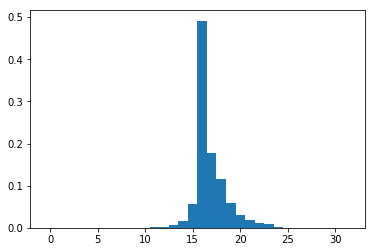

Entropy of distribution: 2.39039661279
Bins:
[[-1.099584]
 [-1.079284]
 [-1.051544]
 [-1.028389]
 [-1.010848]
 [-0.950820]
 [-0.902758]
 [-0.863722]
 [-0.823224]
 [-0.703411]
 [-0.766985]
 [-0.623043]
 [-0.521075]
 [-0.405240]
 [-0.275905]
 [-0.149314]
 [-0.020496]
 [0.121495]
 [0.285160]
 [0.430374]
 [0.556594]
 [0.668902]
 [0.772058]
 [0.880821]
 [0.998547]
 [1.078044]
 [1.091818]
 [1.097515]
 [1.102195]
 [1.106905]
 [1.107880]
 [1.119036]]


In [33]:
if (K.get_value(QUANTIZATION_ON) > 0):
    probs = np.reshape(all_embed, (all_embed.shape[0] * all_embed.shape[1], NBINS))
    hist = np.sum(probs, axis = 0)
    hist /= np.sum(hist)

    sample_hist_bins = np.linspace(0, NBINS - 1, NBINS)
    plt.bar(sample_hist_bins, hist, align = 'center', width = 1)
    plt.show()

    entropy = 0
    for i in hist:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print "Entropy of distribution:", entropy

    print "Bins:"
    print K.eval(QUANT_BINS)

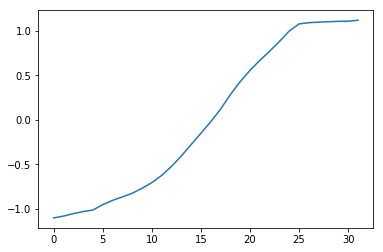

In [34]:
plt.plot(np.sort(np.array(K.eval(QUANT_BINS)).flatten()))
plt.show()

In [35]:
[rate, data] = sciwav.read("./SA1.wav")
data = data.astype(np.float32)
processedWave, wparams = preprocess_waveform(data)
windows = extract_windows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed = np.reshape(windows, (windows.shape[0], WINDOW_SIZE, 1))
embed = encoder.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [36]:
recons = decoder.predict(embed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [37]:
K.eval(enc[-1].SOFTMAX_TEMP)

128.57899

In [38]:
max_pct = np.max(embed[25], axis = -1)
print max_pct
print np.argmax(embed[25], axis = -1)
print np.sum(max_pct > 0.98) / float(max_pct.size)

[1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000 1.000000
 1.000000 1.000000 0.999999 0.999999 0.999974 0.999999 0.999998 0.999983
 0.999998 0.999960 0.999888 0.999522 0.999036 0.990912 0.859401 0.836711
 0.733143 0.600919 0.942145 0.966380 0.967341 0.999999 0.845606 0.999999
 1.000000 1.000000 0.999983 1.000000 0.999998 0.996279 0.998007 1.000000
 0.925581 0.985279 1.000000 0.977593 1.000000 0.782818 1.000000 0.992080
 0.999979 1.000000 0.585895 0.554316 0.999996 0.999997 0.999999 1.000000
 0.999810 1.000000 0.999975 0.999999 1.000000 0.999989 1.000000 0.997516
 1.000000 0.999998 0.831050 0.999999 0.985869 0.999867 0.998276 0.897965
 0.999977 0.999936 0.999997 0.999804 0.999945 0.627761 0.999875 1.000000
 0.993075 0.831541 0.999954 0.999998 0.999961 0.570794 0.999926 0.999997
 0.998573 1.000000 1.000000 1.000000 0.897360 0.934004 1.000000 0.999999
 1.000000 1.000000 1.000000 0.999998 0.529777 1.000

In [39]:
embed_max = np.max(embed, axis = -1)
print np.mean(embed_max)
print np.sum(embed_max > 0.98) / float(embed_max.size)

0.972967
0.849714006696


Original


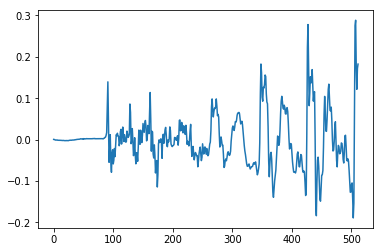

Reconstruction


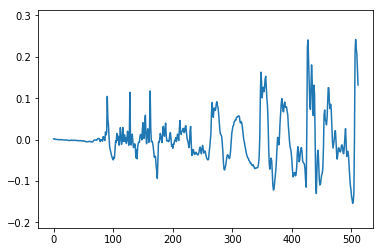

Code (argmax)


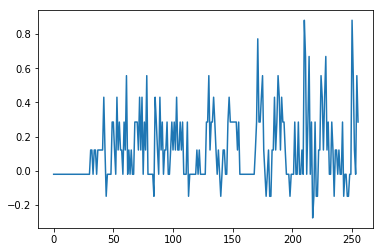

Code (non-argmax)


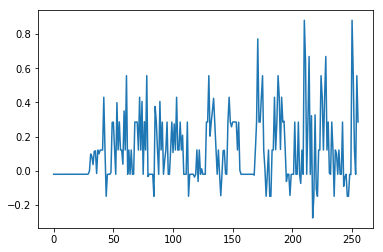

Difference


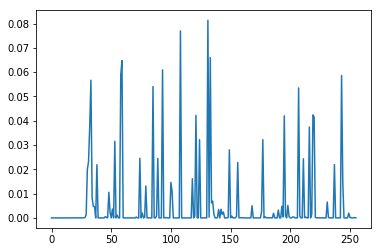

Error


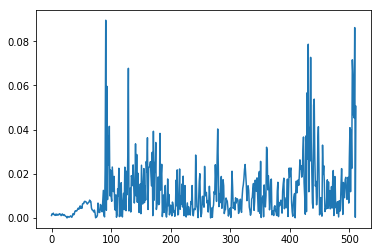

In [40]:
idx = 25

orig = windows[idx].flatten()
recn = recons[idx].flatten()

print "Original"
plt.plot(orig)
ylim = plt.gca().get_ylim()
plt.show()

print "Reconstruction"
plt.plot(recn)
plt.ylim(ylim)
plt.show()

if (K.get_value(QUANTIZATION_ON) > 0):
    print "Code (argmax)"
    argmax_code_vec = embed[idx]
    embed_sum = np.sum(embed[idx], axis = -1)
    argmax_code_vec = np.eye(NBINS)[np.argmax(argmax_code_vec, axis = -1)]
    argmax_code_vec[embed_sum < 0.95] = np.zeros(NBINS)
    argmax_code_vec = unquantize_vec(argmax_code_vec)
    plt.plot(argmax_code_vec)
    plt.show()
    
    print "Code (non-argmax)"
    na_code_vec = embed[idx]
    na_code_vec = unquantize_vec(na_code_vec)
    plt.plot(na_code_vec)
    plt.show()
    
    print "Difference"
    plt.plot(abs(argmax_code_vec - na_code_vec))
    plt.show()
else:
    print "Code (pre-quantization)"
    code_vec = embed[idx][:, :VEC_SIZE].flatten()
    plt.plot(code_vec)
    plt.show()
    
print "Error"
plt.plot(abs(orig - recn))
plt.show()